# Enhanced SRWE: Tikhonov/TSVD/MPM Spectral Recovery + GNN Benchmark

This notebook demonstrates three **Super-Resolved Walk Entropy (SRWE)** spectral recovery methods — **Tikhonov**, **Truncated SVD**, and **Matrix Pencil** — applied to molecular graphs.

**What this demo does:**
1. **Loads** graph data (ZINC-subset) with pre-computed spectral features (eigenvalues, RWSE)
2. **Recomputes** normalized adjacency eigendecomposition P = D^{-1/2} A D^{-1/2}
3. **Runs hyperparameter search** for Tikhonov alpha and TSVD threshold
4. **Recovers spectral weights** per node using all three SRWE methods
5. **Evaluates recovery quality** via Wasserstein-1, cosine similarity, and top-k accuracy
6. **Computes positional encodings** (RWSE, LapPE, SRWE histogram)
7. **Benchmarks** SRWE as a GNN positional encoding against RWSE and LapPE
8. **Visualizes** recovery quality metrics and GNN benchmark results

In [1]:
# ── Install dependencies ──
import subprocess, sys

def _pip(*args):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *args])

# Core scientific packages (from PyPI)
_pip("numpy", "scipy", "scikit-learn", "matplotlib")

# PyTorch CPU-only (use extra-index-url so PyPI is still available)
_pip("torch", "--extra-index-url", "https://download.pytorch.org/whl/cpu")

# Colab-specific version pins
_colab = "google.colab" in sys.modules
if _colab:
    _pip("numpy==1.26.4", "scipy==1.13.1", "scikit-learn==1.6.1")

print("All dependencies installed.")


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


All dependencies installed.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# ── Imports ──
import json
import math
import os
import time
import warnings
from dataclasses import dataclass, field
from typing import Any, Optional

import numpy as np
import scipy.stats
from scipy.linalg import eigh, svd
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
# ── Data loading helper ──
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter3_enhanced_srwe_t/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  ZINC-subset: 6 examples


## Configuration

All tunable parameters are defined below. Adjust to trade off between speed and result quality.

In [5]:
# ── Config: All tunable parameters ──
# Spectral dimensions
RWSE_DIM = 20                 # Random Walk Structural Encoding dimension
PE_DIM = 20                   # Positional encoding dimension
SRWE_HIST_BINS = 20           # Number of histogram bins for SRWE PE
SRWE_HIST_RANGE = (-1.0, 1.0) # Eigenvalue range for histogram

# GNN architecture
GNN_HIDDEN = 64               # Hidden dimension for GCN layers
GNN_LAYERS = 3                # Number of GCN layers
GNN_DROPOUT = 0.1             # Dropout rate

# GNN training
GNN_LR = 1e-3                 # Learning rate
GNN_WD = 1e-5                 # Weight decay
GNN_BATCH_SIZE = 64           # Batch size
GNN_MAX_EPOCHS = 200          # Maximum training epochs
GNN_PATIENCE = 50             # Early stopping patience
GNN_LR_PATIENCE = 20          # LR scheduler patience
GNN_LR_FACTOR = 0.5           # LR reduction factor

# Benchmark
SEEDS = [0, 1, 2]             # Random seeds for GNN training
N_HP_GRAPHS = 200             # Max graphs for hyperparameter search
N_HP_NODES = 20               # Max nodes per graph for HP search
N_HP_ALPHAS = [1e-8, 1e-6, 1e-4, 1e-2, 1.0, None]  # Tikhonov alpha candidates
N_HP_THRESHOLDS = [0.001, 0.01, 0.05, 0.1, 0.2]     # TSVD threshold candidates
MAX_RECOVERY_NODES = 50       # Max nodes for recovery evaluation per graph

print("Config loaded.")

Config loaded.


## Data Structures & Parsing

Define the `GraphData` dataclass and parse raw JSON examples into structured graph objects.

In [6]:
@dataclass
class GraphData:
    """Parsed graph data from the JSON dataset."""
    edge_index: np.ndarray  # [2, E] int
    num_nodes: int
    node_feat: np.ndarray   # [N, F]
    eigenvalues_A: np.ndarray   # from adjacency (stored)
    rwse: np.ndarray        # [N, 20]
    local_spectral_stored: list  # stored top-10 from A
    sri_k20: float
    delta_min: float
    target: Any
    task_type: str
    fold: int
    dataset: str
    row_index: int
    # Recomputed from P = D^{-1/2}AD^{-1/2}
    eigenvalues_P: Optional[np.ndarray] = None
    eigenvectors_P: Optional[np.ndarray] = None
    # Recovered spectral weights
    srwe_tik: Optional[np.ndarray] = None
    srwe_tsvd: Optional[np.ndarray] = None
    srwe_mpm_evals: Optional[np.ndarray] = None
    srwe_mpm_weights: Optional[np.ndarray] = None
    # PE vectors
    pe_rwse: Optional[np.ndarray] = None
    pe_lappe: Optional[np.ndarray] = None
    pe_srwe: Optional[np.ndarray] = None
    # GNN predictions
    predictions: dict = field(default_factory=dict)
    # Recovery metrics (per-node averages)
    recovery_metrics: dict = field(default_factory=dict)
    # Original strings for output
    input_str: str = ""
    output_str: str = ""


def parse_graph(example: dict, dataset_name: str) -> Optional[GraphData]:
    """Parse a single example from the dataset JSON into a GraphData object."""
    try:
        inp = json.loads(example["input"])
        edge_index_raw = inp.get("edge_index", [[], []])
        num_nodes = inp.get("num_nodes", 0)
        if num_nodes == 0:
            return None

        edge_index = np.array(edge_index_raw, dtype=np.int64)
        if edge_index.shape[0] != 2:
            edge_index = np.zeros((2, 0), dtype=np.int64)

        node_feat_raw = inp.get("node_feat", [[0]] * num_nodes)
        node_feat = np.array(node_feat_raw, dtype=np.float32)
        if node_feat.ndim == 1:
            node_feat = node_feat.reshape(-1, 1)

        spectral = inp.get("spectral", {})
        eigenvalues_A = np.array(spectral.get("eigenvalues", []), dtype=np.float64)
        rwse_raw = spectral.get("rwse", [])
        local_spectral = spectral.get("local_spectral", [])
        sri = spectral.get("sri", {})
        sri_k20 = float(sri.get("K=20", 0.0))
        delta_min = float(spectral.get("delta_min", 0.0))

        # Handle RWSE: ensure shape [N, 20]
        if len(rwse_raw) == 0:
            rwse = np.zeros((num_nodes, RWSE_DIM), dtype=np.float64)
        else:
            rwse = np.array(rwse_raw, dtype=np.float64)
            if rwse.ndim == 1:
                rwse = rwse.reshape(1, -1)
            if rwse.shape[0] < num_nodes:
                pad = np.zeros((num_nodes - rwse.shape[0], rwse.shape[1]), dtype=np.float64)
                rwse = np.vstack([rwse, pad])
            if rwse.shape[1] < RWSE_DIM:
                pad = np.zeros((rwse.shape[0], RWSE_DIM - rwse.shape[1]), dtype=np.float64)
                rwse = np.hstack([rwse, pad])
            elif rwse.shape[1] > RWSE_DIM:
                rwse = rwse[:, :RWSE_DIM]

        return GraphData(
            edge_index=edge_index,
            num_nodes=num_nodes,
            node_feat=node_feat,
            eigenvalues_A=eigenvalues_A,
            rwse=rwse,
            local_spectral_stored=local_spectral,
            sri_k20=sri_k20,
            delta_min=delta_min,
            target=example["output"],
            task_type=example.get("metadata_task_type", "regression"),
            fold=example.get("metadata_fold", 0),
            dataset=dataset_name,
            row_index=example.get("metadata_row_index", 0),
            input_str=example["input"],
            output_str=example["output"],
        )
    except Exception as e:
        print(f"Failed to parse graph in {dataset_name}: {e}")
        return None


# Parse all graphs from loaded data
all_datasets = {}
for ds in data.get("datasets", []):
    ds_name = ds["dataset"]
    examples = ds.get("examples", [])
    graphs = []
    for ex in examples:
        g = parse_graph(ex, ds_name)
        if g is not None:
            graphs.append(g)
    all_datasets[ds_name] = graphs

total_graphs = sum(len(v) for v in all_datasets.values())
print(f"Total graphs parsed: {total_graphs}")
for ds, gs in all_datasets.items():
    print(f"  {ds}: {len(gs)} graphs (nodes: {[g.num_nodes for g in gs]})")

Total graphs parsed: 6
  ZINC-subset: 6 graphs (nodes: [33, 18, 26, 25, 28, 30])


## Spectral Recomputation

Recompute the eigendecomposition of the normalized adjacency matrix P = D^{-1/2} A D^{-1/2} for each graph. This provides the ground-truth spectral measure that SRWE methods attempt to recover.

In [7]:
def build_adjacency(edge_index: np.ndarray, num_nodes: int) -> np.ndarray:
    """Build dense adjacency matrix from edge_index [2, E]."""
    A = np.zeros((num_nodes, num_nodes), dtype=np.float64)
    if edge_index.shape[1] > 0:
        src, dst = edge_index[0], edge_index[1]
        valid = (src < num_nodes) & (dst < num_nodes) & (src >= 0) & (dst >= 0)
        A[src[valid], dst[valid]] = 1.0
    A = np.maximum(A, A.T)
    np.fill_diagonal(A, 0)
    return A


def compute_normalized_adjacency_eigen(A: np.ndarray) -> tuple:
    """
    Compute eigenvalues and eigenvectors of P = D^{-1/2} A D^{-1/2}.
    Returns (eigenvalues, eigenvectors) sorted ascending by eigenvalue.
    """
    n = A.shape[0]
    if n == 0:
        return np.array([]), np.array([]).reshape(0, 0)

    degree = A.sum(axis=1)
    d_inv_sqrt = np.zeros(n, dtype=np.float64)
    mask = degree > 1e-12
    d_inv_sqrt[mask] = 1.0 / np.sqrt(degree[mask])

    P = A * d_inv_sqrt[:, None] * d_inv_sqrt[None, :]
    eigenvalues, eigenvectors = eigh(P)
    return eigenvalues, eigenvectors


def recompute_spectral(graph: GraphData) -> None:
    """Recompute normalized adjacency eigendecomposition for a graph."""
    A = build_adjacency(graph.edge_index, graph.num_nodes)
    eigenvalues_P, eigenvectors_P = compute_normalized_adjacency_eigen(A)
    graph.eigenvalues_P = eigenvalues_P
    graph.eigenvectors_P = eigenvectors_P


def consistency_check(graphs: list, n_samples: int = 5) -> dict:
    """Check consistency between stored RWSE and reconstructed moments from P's spectral."""
    errors = []
    for g in graphs[:min(10, len(graphs))]:
        if g.eigenvalues_P is None or g.eigenvectors_P is None:
            continue
        n = g.num_nodes
        n_check = min(n_samples, n)
        for u in range(n_check):
            weights_P = g.eigenvectors_P[u, :] ** 2
            evals_P = g.eigenvalues_P
            for k_idx in range(min(5, RWSE_DIM)):
                k = k_idx + 1
                reconstructed = np.sum(weights_P * (evals_P ** k))
                stored = g.rwse[u, k_idx]
                if abs(stored) > 1e-8:
                    rel_err = abs(reconstructed - stored) / abs(stored)
                else:
                    rel_err = abs(reconstructed - stored)
                errors.append(rel_err)

    mean_err = float(np.mean(errors)) if errors else 0.0
    max_err = float(np.max(errors)) if errors else 0.0
    print(f"Consistency check: mean_rel_error={mean_err:.6f}, max={max_err:.6f}, n_checks={len(errors)}")
    return {"mean_relative_error": mean_err, "max_relative_error": max_err, "n_checks": len(errors)}


# Run spectral recomputation
t0 = time.time()
for ds_name, graphs in all_datasets.items():
    for g in graphs:
        recompute_spectral(g)
print(f"Spectral recomputation done in {time.time()-t0:.2f}s")

# Consistency check
first_ds_graphs = list(all_datasets.values())[0] if all_datasets else []
consistency = consistency_check(first_ds_graphs)

Spectral recomputation done in 0.00s
Consistency check: mean_rel_error=0.000001, max=0.000055, n_checks=150


## SRWE Recovery Methods

Three methods to recover the local spectral measure from RWSE moments:
- **Tikhonov**: Regularized Vandermonde inversion with GCV-selected alpha
- **TSVD**: Truncated SVD of the Vandermonde system
- **Matrix Pencil (MPM)**: Recovers both eigenvalues and weights from moments

In [8]:
def _gcv_alpha(V: np.ndarray, m: np.ndarray) -> float:
    """Generalized cross-validation for Tikhonov regularization parameter."""
    try:
        U, sigma, Vt = svd(V, full_matrices=False)
        K = V.shape[0]
        alphas = np.logspace(-10, 2, 60)
        best_alpha = 1e-4
        best_gcv = float("inf")

        Utm = U.T @ m
        for a in alphas:
            f = sigma**2 / (sigma**2 + a)
            w_alpha = Vt.T @ (f * Utm / np.maximum(sigma, 1e-15))
            res = m - V @ w_alpha
            res_norm2 = np.sum(res**2)
            trace_term = K - np.sum(f)
            if trace_term > 1e-10:
                gcv = K * res_norm2 / (trace_term**2)
                if gcv < best_gcv:
                    best_gcv = gcv
                    best_alpha = a
        return best_alpha
    except Exception:
        return 1e-4


def srwe_tikhonov(moments: np.ndarray, eigenvalues: np.ndarray,
                  alpha: Optional[float] = None) -> np.ndarray:
    """Tikhonov-regularized Vandermonde recovery."""
    K = len(moments)
    n = len(eigenvalues)
    if n == 0:
        return np.array([])

    V = np.zeros((K, n), dtype=np.float64)
    for k in range(K):
        V[k, :] = eigenvalues ** (k + 1)

    if alpha is None:
        alpha = _gcv_alpha(V, moments)

    VtV = V.T @ V
    Vtm = V.T @ moments
    try:
        w = np.linalg.solve(VtV + alpha * np.eye(n), Vtm)
    except np.linalg.LinAlgError:
        w = np.linalg.lstsq(V, moments, rcond=None)[0]

    w = np.maximum(w, 0.0)
    s = w.sum()
    if s > 1e-12:
        w /= s
    return w


def srwe_tsvd(moments: np.ndarray, eigenvalues: np.ndarray,
              threshold: float = 0.01) -> np.ndarray:
    """Truncated SVD recovery."""
    K = len(moments)
    n = len(eigenvalues)
    if n == 0:
        return np.array([])

    V = np.zeros((K, n), dtype=np.float64)
    for k in range(K):
        V[k, :] = eigenvalues ** (k + 1)

    try:
        U, sigma, Vt = svd(V, full_matrices=False)
    except np.linalg.LinAlgError:
        return np.ones(n, dtype=np.float64) / n

    if sigma[0] > 1e-15:
        keep = sigma / sigma[0] > threshold
    else:
        keep = np.ones(len(sigma), dtype=bool)
    r = max(1, int(np.sum(keep)))

    sigma_inv = np.zeros(len(sigma))
    sigma_inv[:r] = 1.0 / np.maximum(sigma[:r], 1e-15)
    w = Vt.T @ (sigma_inv * (U.T @ moments))

    w = np.maximum(w, 0.0)
    s = w.sum()
    if s > 1e-12:
        w /= s
    return w


def srwe_mpm(moments: np.ndarray, pencil_rank: Optional[int] = None,
             noise_threshold: float = 0.01,
             spectral_range: tuple = (-1.0, 1.0)) -> tuple:
    """Matrix Pencil Method: recover both eigenvalues and weights from moments."""
    all_moments = np.concatenate([[1.0], moments])
    M = len(all_moments)
    L = min(10, M // 2)

    H0 = np.zeros((L, L), dtype=np.float64)
    H1 = np.zeros((L, L), dtype=np.float64)
    for i in range(L):
        for j in range(L):
            idx0 = i + j
            idx1 = i + j + 1
            if idx0 < M:
                H0[i, j] = all_moments[idx0]
            if idx1 < M:
                H1[i, j] = all_moments[idx1]

    try:
        U, S, Vt = svd(H0)
    except np.linalg.LinAlgError:
        return np.array([0.0]), np.array([1.0])

    if pencil_rank is not None:
        r = min(pencil_rank, len(S))
    else:
        if S[0] > 1e-15:
            r = int(np.sum(S / S[0] > noise_threshold))
        else:
            r = 1
    r = max(1, min(r, L))

    Ur = U[:, :r]
    Sr = S[:r]
    Vtr = Vt[:r, :]

    try:
        Sr_inv = np.diag(1.0 / np.maximum(Sr, 1e-15))
        M_pencil = Ur.T @ H1 @ Vtr.T @ Sr_inv
        est_evals = np.linalg.eigvals(M_pencil)
    except np.linalg.LinAlgError:
        return np.array([0.0]), np.array([1.0])

    est_evals = np.real(est_evals)
    est_evals = np.clip(est_evals, spectral_range[0], spectral_range[1])
    est_evals = np.unique(np.round(est_evals, 8))
    if len(est_evals) == 0:
        return np.array([0.0]), np.array([1.0])

    n_est = len(est_evals)
    K = len(moments)
    V = np.zeros((K, n_est), dtype=np.float64)
    for k in range(K):
        V[k, :] = est_evals ** (k + 1)

    try:
        weights, _, _, _ = np.linalg.lstsq(V, moments, rcond=None)
    except np.linalg.LinAlgError:
        weights = np.ones(n_est) / n_est

    weights = np.maximum(weights, 0.0)
    s = weights.sum()
    if s > 1e-12:
        weights /= s

    return est_evals, weights

print("SRWE recovery methods defined.")

SRWE recovery methods defined.


## Recovery Evaluation & Hyperparameter Search

Evaluate recovery quality using Wasserstein-1 distance, cosine similarity, and top-k accuracy. Search for the best Tikhonov alpha and TSVD threshold.

In [9]:
def wasserstein1(true_evals, true_weights, est_evals, est_weights) -> float:
    """Compute Wasserstein-1 distance between two discrete measures."""
    if len(true_evals) == 0 or len(est_evals) == 0:
        return float("inf")
    try:
        return float(scipy.stats.wasserstein_distance(true_evals, est_evals, true_weights, est_weights))
    except Exception:
        return float("inf")


def cosine_similarity(w1: np.ndarray, w2: np.ndarray) -> float:
    """Cosine similarity between weight vectors."""
    n1, n2 = np.linalg.norm(w1), np.linalg.norm(w2)
    if n1 < 1e-12 or n2 < 1e-12:
        return 0.0
    return float(np.dot(w1, w2) / (n1 * n2))


def top_k_accuracy(true_weights: np.ndarray, est_weights: np.ndarray, k: int = 5) -> float:
    """Overlap of top-k eigenvalue indices by weight."""
    if len(true_weights) < k or len(est_weights) < k:
        k = min(len(true_weights), len(est_weights))
    if k == 0:
        return 0.0
    true_top = set(np.argsort(-true_weights)[:k])
    est_top = set(np.argsort(-est_weights)[:k])
    return len(true_top & est_top) / k


def evaluate_recovery_node(graph, node_idx, method) -> dict:
    """Evaluate spectral recovery for one node."""
    if graph.eigenvalues_P is None or graph.eigenvectors_P is None:
        return {}
    true_weights = graph.eigenvectors_P[node_idx, :] ** 2
    true_evals = graph.eigenvalues_P

    if method == "tikhonov" and graph.srwe_tik is not None:
        est_weights = graph.srwe_tik[node_idx]
        w1 = wasserstein1(true_evals, true_weights, true_evals, est_weights)
        cos = cosine_similarity(true_weights, est_weights)
        topk = top_k_accuracy(true_weights, est_weights, k=5)
        return {"w1": w1, "cosine": cos, "top5_acc": topk}
    elif method == "tsvd" and graph.srwe_tsvd is not None:
        est_weights = graph.srwe_tsvd[node_idx]
        w1 = wasserstein1(true_evals, true_weights, true_evals, est_weights)
        cos = cosine_similarity(true_weights, est_weights)
        topk = top_k_accuracy(true_weights, est_weights, k=5)
        return {"w1": w1, "cosine": cos, "top5_acc": topk}
    elif method == "mpm":
        if graph.srwe_mpm_evals is not None and graph.srwe_mpm_weights is not None:
            est_evals_node = graph.srwe_mpm_evals[node_idx]
            est_weights_node = graph.srwe_mpm_weights[node_idx]
            if len(est_evals_node) > 0 and len(est_weights_node) > 0:
                w1 = wasserstein1(true_evals, true_weights, est_evals_node, est_weights_node)
                aligned_w = np.zeros(len(true_evals))
                for ev, wt in zip(est_evals_node, est_weights_node):
                    idx = np.argmin(np.abs(true_evals - ev))
                    aligned_w[idx] += wt
                cos = cosine_similarity(true_weights, aligned_w)
                topk = top_k_accuracy(true_weights, aligned_w, k=5)
                return {"w1": w1, "cosine": cos, "top5_acc": topk}
    return {}


def evaluate_recovery_graph(graph, method, max_nodes=None) -> dict:
    """Evaluate spectral recovery averaged over nodes in a graph."""
    if max_nodes is None:
        max_nodes = MAX_RECOVERY_NODES
    n = min(graph.num_nodes, max_nodes)
    metrics_list = []
    for u in range(n):
        m = evaluate_recovery_node(graph, u, method)
        if m:
            metrics_list.append(m)
    if not metrics_list:
        return {}
    result = {}
    for key in metrics_list[0]:
        vals = [m[key] for m in metrics_list if not math.isinf(m[key]) and not math.isnan(m[key])]
        if vals:
            result[f"mean_{key}"] = float(np.mean(vals))
            result[f"std_{key}"] = float(np.std(vals))
    return result


def sri_bin(sri_value: float) -> str:
    """Categorize SRI into bins."""
    if sri_value < 0.5:
        return "very_low"
    elif sri_value < 1.0:
        return "low"
    elif sri_value < 2.0:
        return "medium"
    else:
        return "high"


# ── Hyperparameter Search ──
def hyperparameter_search(val_graphs: list) -> dict:
    """Search for best hyperparameters on validation subset."""
    subset = val_graphs[:N_HP_GRAPHS]
    print(f"Hyperparameter search on {len(subset)} graphs...")

    best_tik_alpha = None
    best_tik_w1 = float("inf")

    for alpha in N_HP_ALPHAS:
        w1_vals = []
        for g in subset:
            if g.eigenvalues_P is None:
                continue
            n = min(g.num_nodes, N_HP_NODES)
            for u in range(n):
                try:
                    w = srwe_tikhonov(g.rwse[u], g.eigenvalues_P, alpha=alpha)
                    true_w = g.eigenvectors_P[u, :] ** 2
                    w1 = wasserstein1(g.eigenvalues_P, true_w, g.eigenvalues_P, w)
                    if not math.isinf(w1) and not math.isnan(w1):
                        w1_vals.append(w1)
                except Exception:
                    pass
        mean_w1 = np.mean(w1_vals) if w1_vals else float("inf")
        print(f"  Tikhonov alpha={alpha}: mean_W1={mean_w1:.6f}")
        if mean_w1 < best_tik_w1:
            best_tik_w1 = mean_w1
            best_tik_alpha = alpha

    best_tsvd_thresh = 0.01
    best_tsvd_w1 = float("inf")

    for thresh in N_HP_THRESHOLDS:
        w1_vals = []
        for g in subset:
            if g.eigenvalues_P is None:
                continue
            n = min(g.num_nodes, N_HP_NODES)
            for u in range(n):
                try:
                    w = srwe_tsvd(g.rwse[u], g.eigenvalues_P, threshold=thresh)
                    true_w = g.eigenvectors_P[u, :] ** 2
                    w1 = wasserstein1(g.eigenvalues_P, true_w, g.eigenvalues_P, w)
                    if not math.isinf(w1) and not math.isnan(w1):
                        w1_vals.append(w1)
                except Exception:
                    pass
        mean_w1 = np.mean(w1_vals) if w1_vals else float("inf")
        print(f"  TSVD threshold={thresh}: mean_W1={mean_w1:.6f}")
        if mean_w1 < best_tsvd_w1:
            best_tsvd_w1 = mean_w1
            best_tsvd_thresh = thresh

    print(f"Best Tikhonov alpha={best_tik_alpha} (W1={best_tik_w1:.6f})")
    print(f"Best TSVD threshold={best_tsvd_thresh} (W1={best_tsvd_w1:.6f})")
    return {
        "best_tik_alpha": best_tik_alpha, "best_tik_w1": best_tik_w1,
        "best_tsvd_thresh": best_tsvd_thresh, "best_tsvd_w1": best_tsvd_w1,
    }


# Run hyperparameter search
hp_graphs = list(all_datasets.values())[0] if all_datasets else []
hp_results = hyperparameter_search(hp_graphs)
best_tik_alpha = hp_results.get("best_tik_alpha")
best_tsvd_thresh = hp_results.get("best_tsvd_thresh", 0.01)

Hyperparameter search on 6 graphs...
  Tikhonov alpha=1e-08: mean_W1=0.082881
  Tikhonov alpha=1e-06: mean_W1=0.091473
  Tikhonov alpha=0.0001: mean_W1=0.105915
  Tikhonov alpha=0.01: mean_W1=0.134481
  Tikhonov alpha=1.0: mean_W1=0.211949
  Tikhonov alpha=None: mean_W1=0.076023
  TSVD threshold=0.001: mean_W1=0.105587
  TSVD threshold=0.01: mean_W1=0.120428
  TSVD threshold=0.05: mean_W1=0.156792
  TSVD threshold=0.1: mean_W1=0.215425
  TSVD threshold=0.2: mean_W1=0.223776
Best Tikhonov alpha=None (W1=0.076023)
Best TSVD threshold=0.001 (W1=0.105587)


## Run SRWE Recovery & Evaluate Quality

Apply all three recovery methods to every graph, then evaluate the recovery quality metrics stratified by SRI (Spectral Resolution Index).

In [10]:
def run_spectral_recovery(graphs: list, best_tik_alpha=None, best_tsvd_thresh=0.01) -> None:
    """Run SRWE recovery methods on all graphs."""
    t0 = time.time()
    for gi, g in enumerate(graphs):
        if g.eigenvalues_P is None:
            continue
        n = g.num_nodes
        evals_P = g.eigenvalues_P

        tik_weights = np.zeros((n, len(evals_P)), dtype=np.float64)
        tsvd_weights = np.zeros((n, len(evals_P)), dtype=np.float64)
        mpm_evals_list = []
        mpm_weights_list = []

        for u in range(n):
            moments = g.rwse[u, :]
            try:
                tik_weights[u] = srwe_tikhonov(moments, evals_P, alpha=best_tik_alpha)
            except Exception:
                tik_weights[u] = np.ones(len(evals_P)) / max(len(evals_P), 1)
            try:
                tsvd_weights[u] = srwe_tsvd(moments, evals_P, threshold=best_tsvd_thresh)
            except Exception:
                tsvd_weights[u] = np.ones(len(evals_P)) / max(len(evals_P), 1)
            if n <= 100 or u < 50:
                try:
                    est_ev, est_w = srwe_mpm(moments)
                    mpm_evals_list.append(est_ev)
                    mpm_weights_list.append(est_w)
                except Exception:
                    mpm_evals_list.append(np.array([0.0]))
                    mpm_weights_list.append(np.array([1.0]))
            else:
                mpm_evals_list.append(np.array([0.0]))
                mpm_weights_list.append(np.array([1.0]))

        g.srwe_tik = tik_weights
        g.srwe_tsvd = tsvd_weights
        g.srwe_mpm_evals = mpm_evals_list
        g.srwe_mpm_weights = mpm_weights_list
    print(f"  Recovery done in {time.time()-t0:.2f}s for {len(graphs)} graphs")


# Run SRWE recovery on all datasets
print("Running SRWE Recovery...")
t0 = time.time()
for ds_name, graphs in all_datasets.items():
    print(f"  Processing {ds_name} ({len(graphs)} graphs)...")
    run_spectral_recovery(graphs, best_tik_alpha=best_tik_alpha, best_tsvd_thresh=best_tsvd_thresh)
print(f"Total SRWE recovery: {time.time()-t0:.2f}s")

# Evaluate recovery quality
print("\nEvaluating Spectral Recovery Quality...")
recovery_results = {}
for ds_name, graphs in all_datasets.items():
    ds_results = {"tikhonov": {}, "tsvd": {}, "mpm": {}}
    sri_stratified = {"tikhonov": {}, "tsvd": {}, "mpm": {}}

    for method in ["tikhonov", "tsvd", "mpm"]:
        all_w1, all_cos, all_topk = [], [], []
        sri_bins_data = {"very_low": [], "low": [], "medium": [], "high": []}

        for g in graphs:
            metrics = evaluate_recovery_graph(g, method)
            if "mean_w1" in metrics:
                all_w1.append(metrics["mean_w1"])
                all_cos.append(metrics.get("mean_cosine", 0))
                all_topk.append(metrics.get("mean_top5_acc", 0))
                bin_name = sri_bin(g.sri_k20)
                sri_bins_data[bin_name].append(metrics["mean_w1"])

        if all_w1:
            ds_results[method] = {
                "mean_w1": float(np.mean(all_w1)),
                "mean_cosine": float(np.mean(all_cos)),
                "mean_top5_acc": float(np.mean(all_topk)),
            }

        for bin_name, vals in sri_bins_data.items():
            if vals:
                sri_stratified[method][bin_name] = {"mean_w1": float(np.mean(vals)), "count": len(vals)}

    recovery_results[ds_name] = {"methods": ds_results, "sri_stratified": sri_stratified}
    for method in ["tikhonov", "tsvd", "mpm"]:
        w1 = ds_results.get(method, {}).get("mean_w1", "N/A")
        cos = ds_results.get(method, {}).get("mean_cosine", "N/A")
        if isinstance(w1, float):
            print(f"  {ds_name} {method}: W1={w1:.4f}, cosine={cos:.4f}")

# Determine best SRWE method
best_method = "tikhonov"
best_w1 = float("inf")
for method in ["tikhonov", "tsvd", "mpm"]:
    w1_all = []
    for ds_name in recovery_results:
        w1_val = recovery_results[ds_name].get("methods", {}).get(method, {}).get("mean_w1")
        if w1_val is not None:
            w1_all.append(w1_val)
    if w1_all and np.mean(w1_all) < best_w1:
        best_w1 = np.mean(w1_all)
        best_method = method
print(f"\nBest SRWE method: {best_method} (overall mean W1={best_w1:.6f})")

Running SRWE Recovery...
  Processing ZINC-subset (6 graphs)...


  Recovery done in 0.10s for 6 graphs
Total SRWE recovery: 0.10s

Evaluating Spectral Recovery Quality...
  ZINC-subset tikhonov: W1=0.0723, cosine=0.7855
  ZINC-subset tsvd: W1=0.1031, cosine=0.6514
  ZINC-subset mpm: W1=0.1220, cosine=0.4062

Best SRWE method: tikhonov (overall mean W1=0.072342)


## Positional Encoding Computation & GNN Model

Compute three types of positional encodings (RWSE, LapPE, SRWE histogram) and define the GCN + Global Attention model for benchmarking.

In [11]:
def compute_pe_rwse(graph: GraphData) -> np.ndarray:
    """RWSE positional encoding: raw walk probabilities [N, 20]."""
    return graph.rwse.astype(np.float32)


def compute_pe_lappe(graph: GraphData) -> np.ndarray:
    """LapPE: squared eigenvector components of normalized adjacency P."""
    n = graph.num_nodes
    if graph.eigenvectors_P is None or len(graph.eigenvalues_P) == 0:
        return np.zeros((n, PE_DIM), dtype=np.float32)

    n_eigs = len(graph.eigenvalues_P)
    k = min(PE_DIM, n_eigs)
    if n_eigs > 1:
        start_idx = max(0, n_eigs - k - 1)
        end_idx = n_eigs - 1
        selected = graph.eigenvectors_P[:, start_idx:end_idx]
    else:
        selected = graph.eigenvectors_P

    pe = selected ** 2
    if pe.shape[1] < PE_DIM:
        pad = np.zeros((n, PE_DIM - pe.shape[1]), dtype=np.float64)
        pe = np.hstack([pe, pad])
    return pe[:, :PE_DIM].astype(np.float32)


def compute_pe_srwe_histogram_vectorized(graph: GraphData, method: str = "tikhonov") -> np.ndarray:
    """Vectorized SRWE histogram PE computation."""
    n = graph.num_nodes
    pe = np.zeros((n, SRWE_HIST_BINS), dtype=np.float32)

    if method in ("tikhonov", "tsvd") and graph.eigenvalues_P is not None:
        weights_mat = graph.srwe_tik if method == "tikhonov" else graph.srwe_tsvd
        if weights_mat is None:
            return pe
        evals = graph.eigenvalues_P
        bin_indices = np.floor(
            (evals - SRWE_HIST_RANGE[0]) / (SRWE_HIST_RANGE[1] - SRWE_HIST_RANGE[0]) * SRWE_HIST_BINS
        ).astype(int)
        bin_indices = np.clip(bin_indices, 0, SRWE_HIST_BINS - 1)
        n_use = min(n, len(weights_mat))
        for u in range(n_use):
            np.add.at(pe[u], bin_indices, weights_mat[u])
    return pe


# Compute PEs for all graphs
print("Computing Positional Encodings...")
for ds_name, graphs in all_datasets.items():
    for g in graphs:
        g.pe_rwse = compute_pe_rwse(g)
        g.pe_lappe = compute_pe_lappe(g)
        g.pe_srwe = compute_pe_srwe_histogram_vectorized(g, method=best_method)
print("PEs computed.")

Computing Positional Encodings...
PEs computed.


## GNN Benchmark

Train a GCN + Global Attention model with each PE type (none, RWSE, LapPE, SRWE) and compare performance on the ZINC-subset regression task (MAE).

In [12]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x, adj):
        h = self.linear(x)
        out = torch.sparse.mm(adj, h)
        return out


def _scatter_softmax(values, batch):
    """Softmax over values grouped by batch indices."""
    num_graphs = batch.max().item() + 1
    max_vals = torch.zeros(num_graphs, device=values.device, dtype=values.dtype)
    max_vals.scatter_reduce_(0, batch, values, reduce="amax", include_self=False)
    max_vals = max_vals[batch]
    exp_vals = torch.exp(values - max_vals)
    sum_vals = torch.zeros(num_graphs, device=values.device, dtype=values.dtype)
    sum_vals.scatter_add_(0, batch, exp_vals)
    return exp_vals / (sum_vals[batch] + 1e-10)


class GCN_GlobalAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNLayer(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.dropout = dropout
        self.gate_nn = nn.Linear(hidden_dim, 1)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x, adj, batch):
        h = self.input_proj(x)
        h = F.relu(h)
        for conv, bn in zip(self.convs, self.bns):
            h_new = conv(h, adj)
            h_new = bn(h_new)
            h_new = F.relu(h_new)
            h_new = F.dropout(h_new, p=self.dropout, training=self.training)
            h = h + h_new
        gate = self.gate_nn(h)
        gate = _scatter_softmax(gate.squeeze(-1), batch)
        h_weighted = h * gate.unsqueeze(-1)
        num_graphs = batch.max().item() + 1
        graph_emb = torch.zeros(num_graphs, h.shape[1], device=h.device, dtype=h.dtype)
        graph_emb.scatter_add_(0, batch.unsqueeze(-1).expand_as(h_weighted), h_weighted)
        return self.head(graph_emb)


def _parse_target(target_str, task_type):
    """Parse target string into numpy array."""
    try:
        val = json.loads(target_str)
        if isinstance(val, list):
            return np.array(val, dtype=np.float32)
        else:
            return np.array([float(val)], dtype=np.float32)
    except (json.JSONDecodeError, ValueError):
        try:
            return np.array([float(target_str)], dtype=np.float32)
        except ValueError:
            return np.array([0.0], dtype=np.float32)


def collate_graphs(graphs: list, pe_type: str = "none", device=DEVICE):
    """Collate a list of graphs into a batch."""
    all_x, all_src, all_dst, all_batch, all_targets = [], [], [], [], []
    node_offset = 0

    for gi, g in enumerate(graphs):
        n = g.num_nodes
        feat = g.node_feat.astype(np.float32)

        if pe_type == "rwse":
            pe = g.pe_rwse if g.pe_rwse is not None else np.zeros((n, PE_DIM), dtype=np.float32)
        elif pe_type == "lappe":
            pe = g.pe_lappe if g.pe_lappe is not None else np.zeros((n, PE_DIM), dtype=np.float32)
        elif pe_type == "srwe":
            pe = g.pe_srwe if g.pe_srwe is not None else np.zeros((n, PE_DIM), dtype=np.float32)
        else:
            pe = np.zeros((n, PE_DIM), dtype=np.float32)

        x = np.hstack([feat, pe])
        all_x.append(x)

        if g.edge_index.shape[1] > 0:
            all_src.append(g.edge_index[0] + node_offset)
            all_dst.append(g.edge_index[1] + node_offset)

        self_nodes = np.arange(n) + node_offset
        all_src.append(self_nodes)
        all_dst.append(self_nodes)
        all_batch.append(np.full(n, gi, dtype=np.int64))
        target = _parse_target(g.target, g.task_type)
        all_targets.append(target)
        node_offset += n

    x = np.vstack(all_x)
    src = np.concatenate(all_src)
    dst = np.concatenate(all_dst)
    batch_vec = np.concatenate(all_batch)

    total_nodes = node_offset
    degree = np.zeros(total_nodes, dtype=np.float32)
    np.add.at(degree, dst, 1.0)
    d_inv_sqrt = np.zeros(total_nodes, dtype=np.float32)
    mask = degree > 0
    d_inv_sqrt[mask] = 1.0 / np.sqrt(degree[mask])
    edge_weight = d_inv_sqrt[src] * d_inv_sqrt[dst]

    x_t = torch.tensor(x, dtype=torch.float32, device=device)
    indices = torch.tensor(np.stack([src, dst]), dtype=torch.long, device=device)
    values = torch.tensor(edge_weight, dtype=torch.float32, device=device)
    adj_t = torch.sparse_coo_tensor(indices, values, (total_nodes, total_nodes)).coalesce()
    batch_t = torch.tensor(batch_vec, dtype=torch.long, device=device)
    target_t = torch.tensor(np.array(all_targets), dtype=torch.float32, device=device)

    return x_t, adj_t, batch_t, target_t


def split_graphs(graphs, train_ratio=0.7, val_ratio=0.15, seed=42):
    """Split graphs into train/val/test sets."""
    folds = set(g.fold for g in graphs)
    if folds == {0, 1, 2}:
        train = [g for g in graphs if g.fold == 0]
        val = [g for g in graphs if g.fold == 1]
        test = [g for g in graphs if g.fold == 2]
        return train, val, test
    rng = np.random.RandomState(seed)
    n = len(graphs)
    indices = rng.permutation(n)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = [graphs[i] for i in indices[:n_train]]
    val = [graphs[i] for i in indices[n_train:n_train + n_val]]
    test = [graphs[i] for i in indices[n_train + n_val:]]
    return train, val, test


def train_gnn(train_graphs, val_graphs, pe_type, task_type, output_dim, seed,
              max_epochs=None, patience=None, batch_size=None):
    """Train a GCN model and return it."""
    if max_epochs is None: max_epochs = GNN_MAX_EPOCHS
    if patience is None: patience = GNN_PATIENCE
    if batch_size is None: batch_size = GNN_BATCH_SIZE

    torch.manual_seed(seed)
    np.random.seed(seed)

    feat_dim = train_graphs[0].node_feat.shape[1] if train_graphs else 1
    input_dim = feat_dim + PE_DIM

    model = GCN_GlobalAttention(
        input_dim=input_dim, hidden_dim=GNN_HIDDEN, output_dim=output_dim,
        num_layers=GNN_LAYERS, dropout=GNN_DROPOUT,
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=GNN_LR, weight_decay=GNN_WD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=GNN_LR_PATIENCE, factor=GNN_LR_FACTOR
    )
    criterion = nn.L1Loss() if task_type != "classification" else nn.BCEWithLogitsLoss()

    best_val_loss = float("inf")
    best_state = None
    wait = 0

    for epoch in range(max_epochs):
        model.train()
        rng_ep = np.random.RandomState(seed * 1000 + epoch)
        indices = rng_ep.permutation(len(train_graphs))
        total_loss, n_batches = 0.0, 0

        for start in range(0, len(indices), batch_size):
            batch_idx = indices[start:start + batch_size]
            batch_graphs = [train_graphs[i] for i in batch_idx]
            try:
                x, adj, batch_vec, targets = collate_graphs(batch_graphs, pe_type)
            except Exception:
                continue
            optimizer.zero_grad()
            out = model(x, adj, batch_vec)
            if out.shape != targets.shape:
                min_cols = min(out.shape[1], targets.shape[1])
                out = out[:, :min_cols]; targets = targets[:, :min_cols]
            loss = criterion(out, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item(); n_batches += 1

        model.eval()
        val_loss, n_val_batches = 0.0, 0
        with torch.no_grad():
            for start in range(0, len(val_graphs), batch_size):
                batch_graphs = val_graphs[start:start + batch_size]
                try:
                    x, adj, batch_vec, targets = collate_graphs(batch_graphs, pe_type)
                    out = model(x, adj, batch_vec)
                    if out.shape != targets.shape:
                        min_cols = min(out.shape[1], targets.shape[1])
                        out = out[:, :min_cols]; targets = targets[:, :min_cols]
                    loss = criterion(out, targets)
                    val_loss += loss.item(); n_val_batches += 1
                except Exception:
                    continue

        avg_val_loss = val_loss / max(n_val_batches, 1)
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return model


def predict_gnn(model, graphs, pe_type, batch_size=None):
    """Run inference and return per-graph predictions."""
    if batch_size is None: batch_size = GNN_BATCH_SIZE
    model.eval()
    all_preds = []
    with torch.no_grad():
        for start in range(0, len(graphs), batch_size):
            batch_graphs = graphs[start:start + batch_size]
            try:
                x, adj, batch_vec, _ = collate_graphs(batch_graphs, pe_type)
                out = model(x, adj, batch_vec)
                preds = out.cpu().numpy()
                for i in range(len(batch_graphs)):
                    all_preds.append(preds[i])
            except Exception:
                for _ in batch_graphs:
                    all_preds.append(np.array([0.0]))
    return all_preds


def compute_metric(predictions, targets, task_type):
    """Compute task-specific metrics."""
    if not predictions or not targets:
        return {}
    preds = np.array([p.flatten() for p in predictions])
    tgts = np.array([t.flatten() for t in targets])
    min_cols = min(preds.shape[1], tgts.shape[1])
    preds = preds[:, :min_cols]; tgts = tgts[:, :min_cols]
    if task_type == "classification":
        try:
            probs = 1.0 / (1.0 + np.exp(-preds))
            ap = average_precision_score(tgts, probs, average="macro")
            return {"AP": float(ap)}
        except Exception:
            return {"AP": 0.0}
    else:
        mae = float(np.mean(np.abs(preds - tgts)))
        return {"MAE": mae}

print("GNN model and training utilities defined.")

GNN model and training utilities defined.


In [13]:
# ── Run GNN Benchmark ──
print("=" * 60)
print("GNN Benchmark")
print("=" * 60)

gnn_results = {}
pe_types_to_test = ["none", "rwse", "lappe", "srwe"]

for ds_name, all_ds_graphs in all_datasets.items():
    graphs = all_ds_graphs
    task_type = graphs[0].task_type
    output_dim = 1  # ZINC regression
    metric_name = "MAE"

    train_g, val_g, test_g = split_graphs(graphs)
    # Ensure non-empty splits
    if not val_g:
        val_g = train_g[:1]
    if not test_g:
        test_g = train_g[-1:]

    print(f"\n  {ds_name}: train={len(train_g)}, val={len(val_g)}, test={len(test_g)}")

    ds_gnn_results = {}
    for pe_type in pe_types_to_test:
        seed_results = []
        for seed in SEEDS:
            t_train_start = time.time()
            print(f"    Training {pe_type} seed={seed}...", end=" ")

            try:
                model = train_gnn(train_g, val_g, pe_type, task_type, output_dim, seed)
                test_preds = predict_gnn(model, test_g, pe_type)
                test_targets = [_parse_target(g.target, task_type) for g in test_g]
                test_metrics = compute_metric(test_preds, test_targets, task_type)

                elapsed = time.time() - t_train_start
                print(f"{test_metrics}, time={elapsed:.1f}s")
                seed_results.append(test_metrics)
                del model
            except Exception as e:
                print(f"Failed: {e}")
                seed_results.append({metric_name: float("nan")})

        if seed_results:
            vals = [r.get(metric_name, float("nan")) for r in seed_results]
            valid_vals = [v for v in vals if not math.isnan(v)]
            if valid_vals:
                ds_gnn_results[pe_type] = {
                    "mean": float(np.mean(valid_vals)),
                    "std": float(np.std(valid_vals)),
                    "per_seed": vals,
                }

    gnn_results[ds_name] = {
        "metric": metric_name,
        "task_type": task_type,
        "results": ds_gnn_results,
    }
    summary = {k: f"{v['mean']:.4f}" for k, v in ds_gnn_results.items()}
    print(f"\n  {ds_name} GNN results ({metric_name}): {summary}")

GNN Benchmark

  ZINC-subset: train=4, val=1, test=1
    Training none seed=0... 

{'MAE': 0.9403964281082153}, time=0.7s
    Training none seed=1... 

{'MAE': 1.0271214246749878}, time=0.8s
    Training none seed=2... 

{'MAE': 0.9699163436889648}, time=0.3s
    Training rwse seed=0... 

{'MAE': 0.9705166816711426}, time=0.3s
    Training rwse seed=1... 

{'MAE': 1.0360552072525024}, time=0.3s
    Training rwse seed=2... 

{'MAE': 0.9713138341903687}, time=0.2s
    Training lappe seed=0... 

{'MAE': 0.9697707891464233}, time=0.2s
    Training lappe seed=1... 

{'MAE': 1.031253457069397}, time=1.2s
    Training lappe seed=2... 

{'MAE': 0.9757547974586487}, time=1.5s
    Training srwe seed=0... 

{'MAE': 0.9413794875144958}, time=1.4s
    Training srwe seed=1... 

{'MAE': 1.0206691026687622}, time=0.7s
    Training srwe seed=2... 

{'MAE': 0.9682464599609375}, time=0.4s

  ZINC-subset GNN results (MAE): {'none': '0.9791', 'rwse': '0.9926', 'lappe': '0.9923', 'srwe': '0.9768'}


## Results Visualization

Summarize the spectral recovery quality and GNN benchmark results.

SPECTRAL RECOVERY QUALITY
Method        W1 Distance   Cosine Sim    Top-5 Acc
--------------------------------------------------
tikhonov     0.0723        0.7855        0.6764
tsvd         0.1031        0.6514        0.4878
mpm          0.1220        0.4062        0.3401

Best recovery method: tikhonov

GNN BENCHMARK RESULTS

ZINC-subset (MAE):
  PE Type          Mean        Std
  --------------------------------
  none           0.9791     0.0360
  rwse           0.9926     0.0307
  lappe          0.9923     0.0277
  srwe           0.9768     0.0329


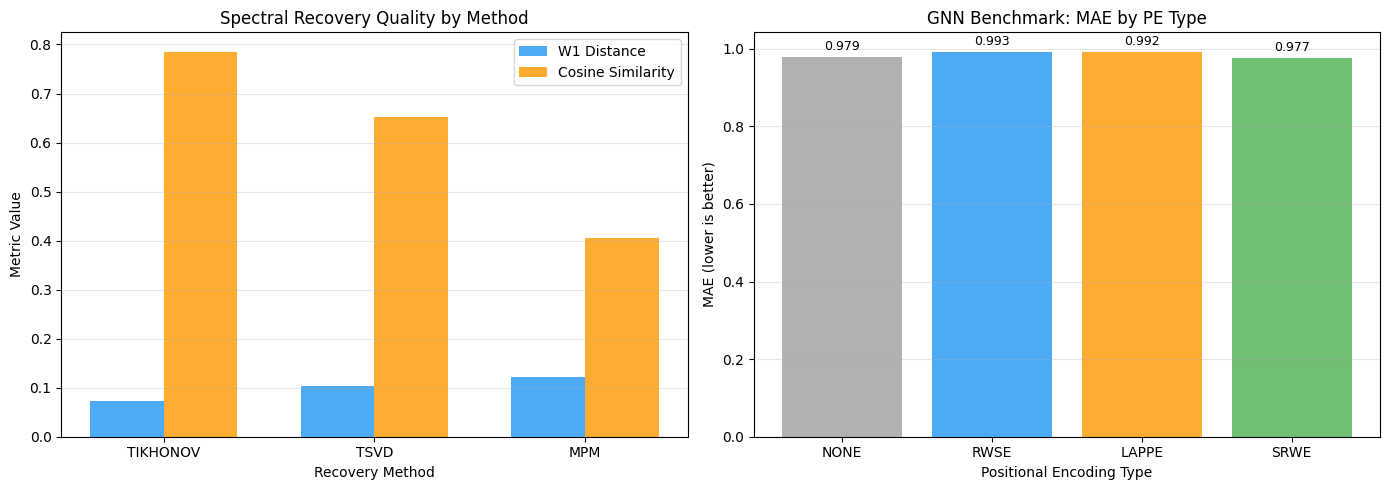


Results saved to results.png


In [14]:
# ── Print Summary Tables ──
print("=" * 70)
print("SPECTRAL RECOVERY QUALITY")
print("=" * 70)
print(f"{'Method':<12} {'W1 Distance':>12} {'Cosine Sim':>12} {'Top-5 Acc':>12}")
print("-" * 50)
for ds_name, res in recovery_results.items():
    for method in ["tikhonov", "tsvd", "mpm"]:
        m = res.get("methods", {}).get(method, {})
        if m:
            print(f"{method:<12} {m.get('mean_w1', 0):.4f}        {m.get('mean_cosine', 0):.4f}        {m.get('mean_top5_acc', 0):.4f}")

print(f"\nBest recovery method: {best_method}")

print("\n" + "=" * 70)
print("GNN BENCHMARK RESULTS")
print("=" * 70)
for ds_name, ds_res in gnn_results.items():
    metric_name = ds_res["metric"]
    print(f"\n{ds_name} ({metric_name}):")
    print(f"  {'PE Type':<10} {'Mean':>10} {'Std':>10}")
    print(f"  {'-'*32}")
    for pe_type in pe_types_to_test:
        r = ds_res.get("results", {}).get(pe_type, {})
        if r:
            print(f"  {pe_type:<10} {r['mean']:>10.4f} {r.get('std', 0):>10.4f}")

# ── Visualization ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Spectral Recovery W1 by Method
ax = axes[0]
methods = ["tikhonov", "tsvd", "mpm"]
colors = ["#2196F3", "#FF9800", "#4CAF50"]
for ds_name, res in recovery_results.items():
    w1_vals = [res.get("methods", {}).get(m, {}).get("mean_w1", 0) for m in methods]
    cos_vals = [res.get("methods", {}).get(m, {}).get("mean_cosine", 0) for m in methods]

x = np.arange(len(methods))
width = 0.35
w1_vals = [recovery_results.get(list(recovery_results.keys())[0], {}).get("methods", {}).get(m, {}).get("mean_w1", 0) for m in methods]
cos_vals = [recovery_results.get(list(recovery_results.keys())[0], {}).get("methods", {}).get(m, {}).get("mean_cosine", 0) for m in methods]
bars1 = ax.bar(x - width/2, w1_vals, width, label="W1 Distance", color="#2196F3", alpha=0.8)
bars2 = ax.bar(x + width/2, cos_vals, width, label="Cosine Similarity", color="#FF9800", alpha=0.8)
ax.set_xlabel("Recovery Method")
ax.set_ylabel("Metric Value")
ax.set_title("Spectral Recovery Quality by Method")
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in methods])
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Plot 2: GNN Benchmark MAE by PE Type
ax = axes[1]
for ds_name, ds_res in gnn_results.items():
    results = ds_res.get("results", {})
    pe_names = [pt for pt in pe_types_to_test if pt in results]
    mae_vals = [results[pt]["mean"] for pt in pe_names]
    x = np.arange(len(pe_names))
    bars = ax.bar(x, mae_vals, color=["#9E9E9E", "#2196F3", "#FF9800", "#4CAF50"][:len(pe_names)], alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([pt.upper() for pt in pe_names])
    # Add value labels on bars
    for bar, val in zip(bars, mae_vals):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f"{val:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_xlabel("Positional Encoding Type")
ax.set_ylabel("MAE (lower is better)")
ax.set_title("GNN Benchmark: MAE by PE Type")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("results.png", dpi=100, bbox_inches="tight")
plt.show()
print("\nResults saved to results.png")